# Bias Analysis Comparison: Full vs. Restricted vs. Pageview-Filtered

This notebook loads **cached results** from three analysis runs and displays them side-by-side for comparison:

| Dataset | Description |
|---------|-------------|
| **Full** | All available data, no filtering |
| **Restricted** | Only individuals born 1750–1950 |
| **Pageview** | Language-specific top-20% pageview filter (quantile 0.8) |

For every (language, attribute) combination the notebook shows:
- **AUC heatmaps** — normalised, side-by-side
- **Edge retention curves** — per-pair fraction retained vs threshold
- **Node retention curves** — per-attribute-value fraction retained vs threshold

## Setup

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src import analysis

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print(f"Project root: {project_root}")
print("✓ Setup complete")

Project root: /home/vlr/Workspaces/WikipediaBiasProject/PyProject
✓ Setup complete


## Configuration

In [2]:
# ============================================================================
# PARAMETERS — must match the values used when running each analysis
# ============================================================================

DATASET_NAME = 'SpotlightWeightSource_0102_0505_fullmatch_corrected'
BASE_OUTPUT_DIR = os.path.join(project_root, 'data/out/plots')

SELECTED_LANGUAGES = ['en', 'de', 'fr', 'it', 'es']
ATTRIBUTES = ['gender', 'un_subregion', 'bigperiod_birth']

MIN_EDGES = 500
RESOLUTION = 50
LOGSPACE_LOWER_BOUND = -14

# Time restriction used in the restricted analysis
MIN_YEAR = 1750
MAX_YEAR = 1950

# Pageview filter used
ANALYSIS_QUANTILE = 0.8
USE_GLOBAL_PAGEVIEWS = False

# ============================================================================
# DISPLAY OPTIONS
# ============================================================================

# Languages to compare (set to None for all, including 'all')
DISPLAY_LANGUAGES = SELECTED_LANGUAGES + ['all']

# Save comparison plots?
SAVE_PLOTS = True
COMPARISON_OUTPUT_DIR = os.path.join(BASE_OUTPUT_DIR, 'comparison')

print(f"Comparing {len(DISPLAY_LANGUAGES)} languages × {len(ATTRIBUTES)} attributes")
print(f"Languages: {DISPLAY_LANGUAGES}")
print(f"Attributes: {ATTRIBUTES}")

Comparing 6 languages × 3 attributes
Languages: ['en', 'de', 'fr', 'it', 'es', 'all']
Attributes: ['gender', 'un_subregion', 'bigperiod_birth']


## Load Cached Results

In [3]:
# Build output dirs for each analysis using the same function
common_params = dict(
    base_output_dir=BASE_OUTPUT_DIR,
    dataset_name=DATASET_NAME,
    resolution=RESOLUTION,
    min_edges=MIN_EDGES,
    selected_languages=SELECTED_LANGUAGES,
    attributes=ATTRIBUTES,
    logspace_lower_bound=LOGSPACE_LOWER_BOUND,
)

dirs_full = analysis.build_analysis_output_dirs(**common_params, filter_description='full')
dirs_restricted = analysis.build_analysis_output_dirs(**common_params, filter_description=f'restricted_{MIN_YEAR}_{MAX_YEAR}')

pv_filter = f"pageview_q{ANALYSIS_QUANTILE}_{'global' if USE_GLOBAL_PAGEVIEWS else 'lang'}"
dirs_pageview = analysis.build_analysis_output_dirs(**common_params, filter_description=pv_filter)

# Load cached results
DATASETS = {}  # label -> (retention_results, short_label, color)

for label, dirs in [('Full', dirs_full), (f'Restricted {MIN_YEAR}–{MAX_YEAR}', dirs_restricted), (f'Pageview q{ANALYSIS_QUANTILE}', dirs_pageview)]:
    print(f"Loading {label} from: {os.path.basename(dirs['base'])}")
    results = analysis.load_cached_analysis_results(dirs, SELECTED_LANGUAGES, ATTRIBUTES)
    if results is None:
        print(f"  ⚠ Cache not found! Run the corresponding analysis notebook first.")
    else:
        print(f"  ✓ Loaded ({len(results)} languages)")
        DATASETS[label] = results

DATASET_LABELS = list(DATASETS.keys())
print(f"\n✓ {len(DATASETS)}/{3} datasets loaded successfully")

Loading Full from: SpotlightWeightSource_0102_0505_fullmatch_corrected_full_res50_min500_langs5_attrs3
  ✓ Loaded (6 languages)
Loading Restricted 1750–1950 from: SpotlightWeightSource_0102_0505_fullmatch_corrected_restricted_1750_1950_res50_min500_langs5_attrs3
  ✓ Loaded (6 languages)
Loading Pageview q0.8 from: SpotlightWeightSource_0102_0505_fullmatch_corrected_pageview_q0.8_lang_res50_min500_langs5_attrs3
  ✓ Loaded (6 languages)

✓ 3/3 datasets loaded successfully


## Comparison Helper Functions

In [4]:
def _unpack(result_tuple):
    """Unpack a result tuple (handles 3-tuple and 4-tuple formats)."""
    if len(result_tuple) == 4:
        return result_tuple[0], result_tuple[1], result_tuple[2]
    return result_tuple[0], result_tuple[1], result_tuple[2]


def _normalize_auc(auc_matrix, min_edges_val, edge_results):
    """Normalize AUC matrix to [0,1] and mask low-edge cells."""
    m = auc_matrix.copy()
    for src in m.index:
        for trg in m.columns:
            n = next((r['n_edges'] for r in edge_results if r['pair'] == (src, trg)), 0)
            if n < min_edges_val:
                m.loc[src, trg] = np.nan
    valid = m.values[np.isfinite(m.values)]
    if len(valid) > 1 and np.nanmin(m.values) != np.nanmax(m.values):
        m = (m - np.nanmin(m.values)) / (np.nanmax(m.values) - np.nanmin(m.values))
    # Sort by diagonal
    diag = np.diag(m.values)
    if not np.all(np.isnan(diag)):
        order = np.argsort(np.nan_to_num(diag, nan=np.inf))
        labels = m.index[order]
        m = m.loc[labels, labels]
    return m


# Attributes with too many categories for a readable legend
LEGEND_SUPPRESSED_ATTRS = {'bigperiod_birth'}


def plot_comparison_heatmaps(lang, attr, datasets, dataset_labels, min_edges_val, save_dir=None):
    """Plot side-by-side AUC heatmaps for multiple datasets."""
    n = len(dataset_labels)
    fig, axes = plt.subplots(1, n, figsize=(4.2 * n, 3.5))
    if n == 1:
        axes = [axes]

    cmap = plt.colormaps.get_cmap('RdYlGn').copy()
    cmap.set_bad('darkgray')

    for ax, ds_label in zip(axes, dataset_labels):
        results = datasets[ds_label]
        if lang not in results or attr not in results[lang]:
            ax.set_title(f"{ds_label}\n(no data)", fontsize=9)
            ax.axis('off')
            continue

        edge_res, _, auc_matrix = _unpack(results[lang][attr])
        norm = _normalize_auc(auc_matrix, min_edges_val, edge_res)

        if norm.isna().all().all():
            ax.set_title(f"{ds_label}\n(insufficient data)", fontsize=9)
            ax.axis('off')
            continue

        sns.heatmap(
            norm, annot=True, cmap=cmap, fmt='.2f',
            mask=np.isnan(norm), ax=ax, cbar=False,
            vmin=0, vmax=1, square=True, linewidths=0.5,
            annot_kws={'size': 8}
        )
        ax.set_title(ds_label, fontsize=10, fontweight='bold')
        ax.tick_params(labelsize=8)
        ax.set_xlabel('Target', fontsize=8)
        ax.set_ylabel('Source', fontsize=8)

    fig.suptitle(f'Normalized AUC — {attr}  [{lang.upper()}]', fontsize=11, fontweight='bold', y=1.02)
    plt.tight_layout()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        fig.savefig(os.path.join(save_dir, f'heatmap_comparison_{lang}_{attr}.png'),
                    dpi=200, bbox_inches='tight')

    plt.show()


def plot_comparison_curves(lang, attr, datasets, dataset_labels, min_edges_val,
                           curve_type='edges', save_dir=None, show_legend=True):
    """
    Plot side-by-side retention curves for multiple datasets.

    curve_type: 'edges' for edge retention, 'nodes' for node retention.
    show_legend: if False, legends are suppressed (useful for many-category attributes).
    """
    n = len(dataset_labels)
    fig, axes = plt.subplots(1, n, figsize=(4.5 * n, 3.2))
    if n == 1:
        axes = [axes]

    for ax, ds_label in zip(axes, dataset_labels):
        results = datasets[ds_label]
        if lang not in results or attr not in results[lang]:
            ax.set_title(f"{ds_label}\n(no data)", fontsize=9)
            ax.axis('off')
            continue

        edge_res, node_res, _ = _unpack(results[lang][attr])

        if curve_type == 'edges':
            filtered = [r for r in edge_res if r['n_edges'] >= min_edges_val]
            if not filtered:
                ax.set_title(f"{ds_label}\n(no pairs ≥ {min_edges_val} edges)", fontsize=9)
                continue
            for r in filtered:
                lbl = f"{r['pair'][0]}→{r['pair'][1]}\n(n={r['n_edges']:,})"
                ax.plot(r['x'], r['edges_fractions'], label=lbl, alpha=0.7, linewidth=1.2)
            ax.set_ylabel('Fraction retained', fontsize=8)
        else:  # nodes
            has_data = False
            for attr_value, nr in node_res.items():
                if nr['n_edges'] < min_edges_val:
                    continue
                has_data = True
                lbl = f"{attr_value}\n(nodes={nr['n_total_nodes']:,})"
                ax.plot(nr['x'], nr['nodes_fraction'], label=lbl, alpha=0.7, linewidth=1.2)
            if not has_data:
                ax.set_title(f"{ds_label}\n(insufficient data)", fontsize=9)
                continue
            ax.set_ylabel('Fraction retained', fontsize=8)

        ax.set_title(ds_label, fontsize=10, fontweight='bold')
        ax.set_xlabel('-log(1-threshold)', fontsize=8)
        if show_legend:
            ax.legend(loc='lower left', fontsize=6)
        ax.tick_params(labelsize=7)
        ax.grid(True, alpha=0.3)

    kind = 'Edge' if curve_type == 'edges' else 'Node'
    fig.suptitle(f'{kind} Retention — {attr}  [{lang.upper()}]', fontsize=11, fontweight='bold', y=1.02)
    plt.tight_layout()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        fig.savefig(os.path.join(save_dir, f'{curve_type}_retention_comparison_{lang}_{attr}.png'),
                    dpi=200, bbox_inches='tight')

    plt.show()


print("✓ Comparison functions defined")

✓ Comparison functions defined


---
## Comparison: AUC Heatmaps

For each (language, attribute) — three heatmaps side-by-side.

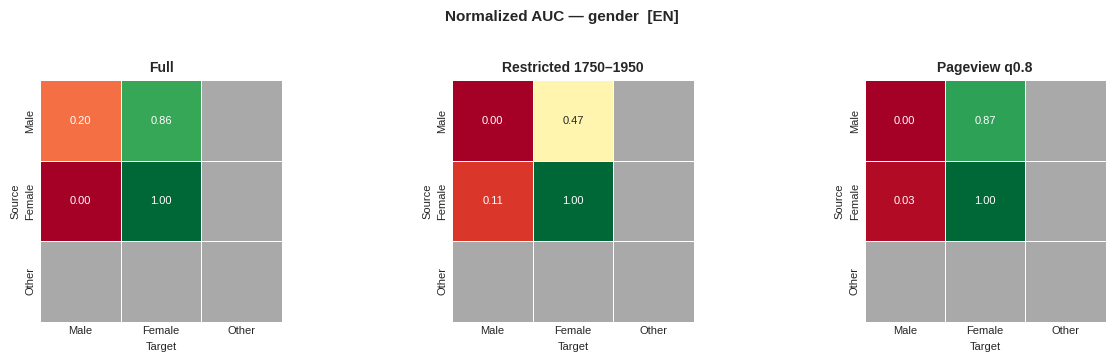

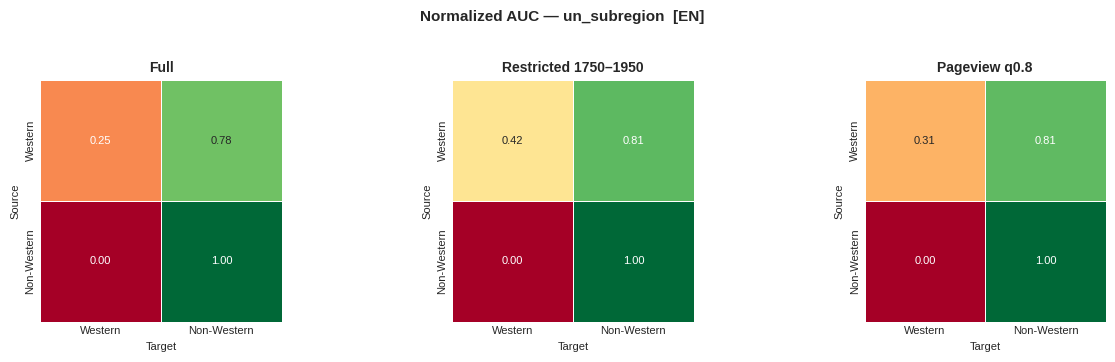

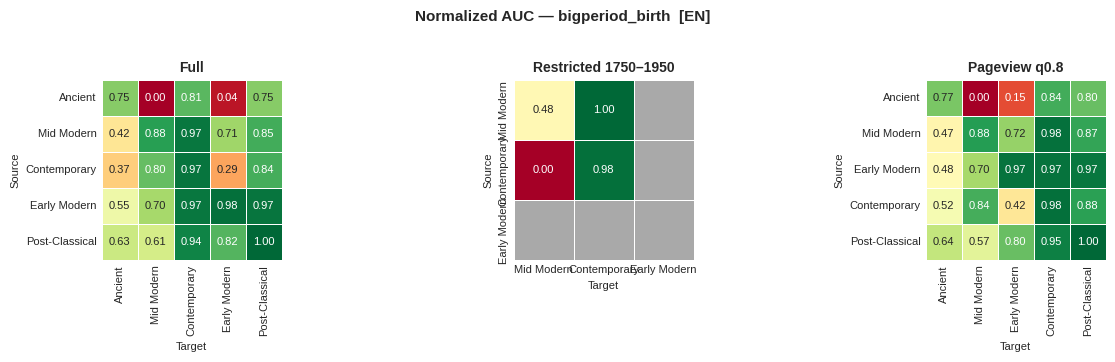

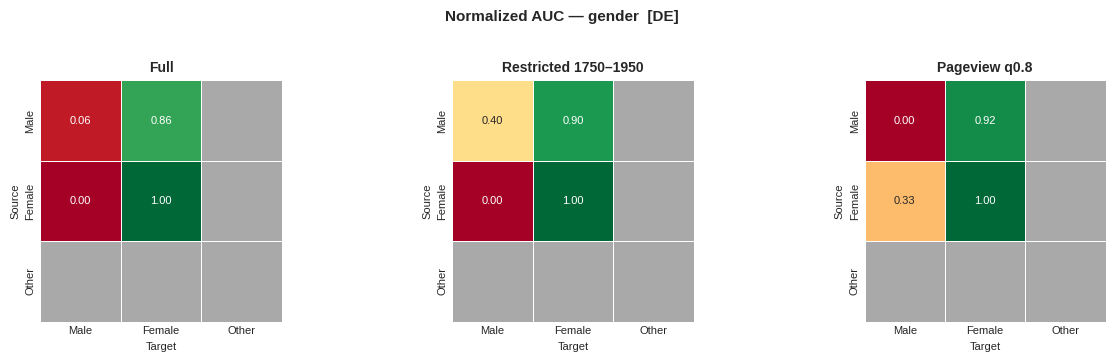

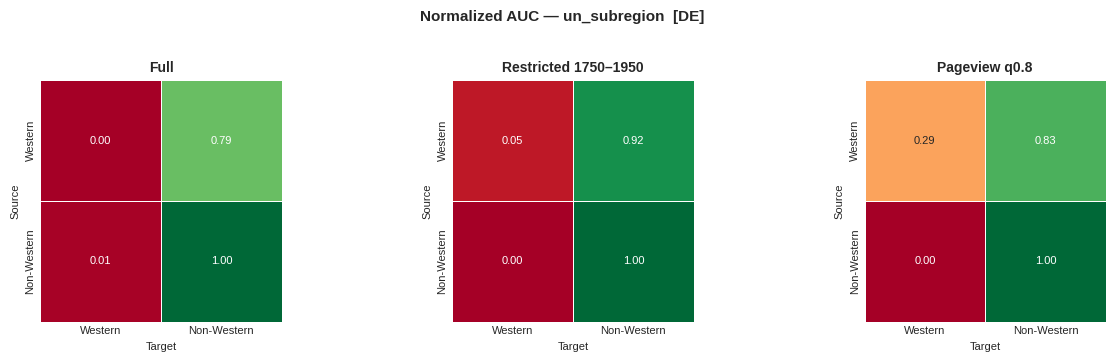

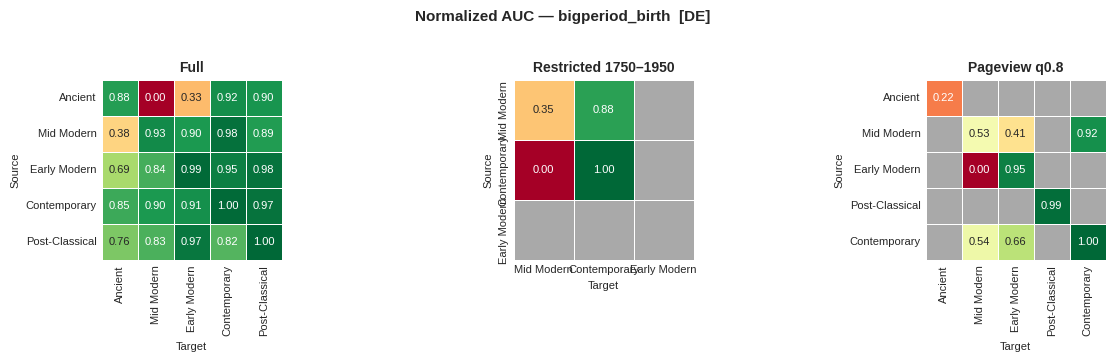

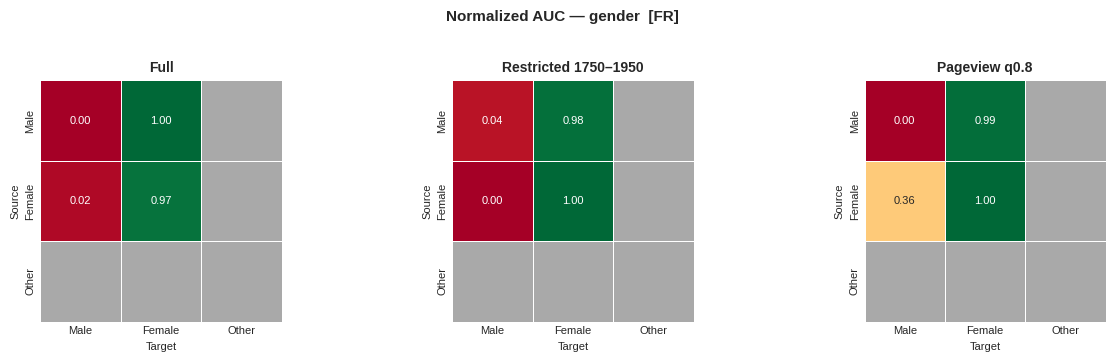

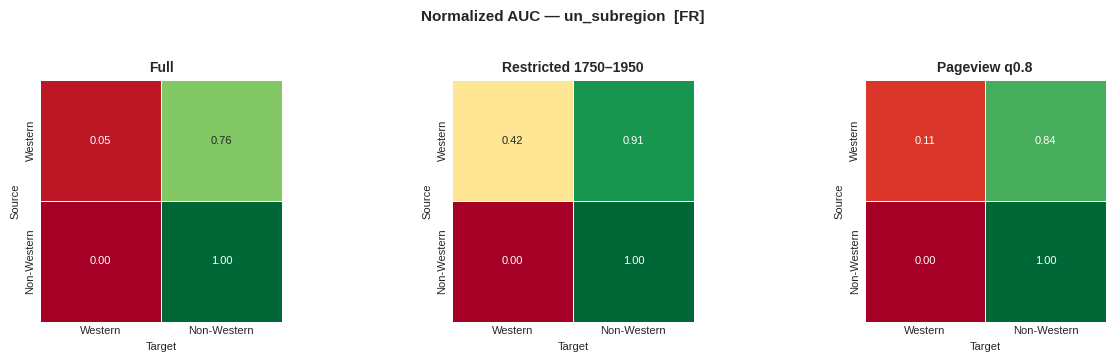

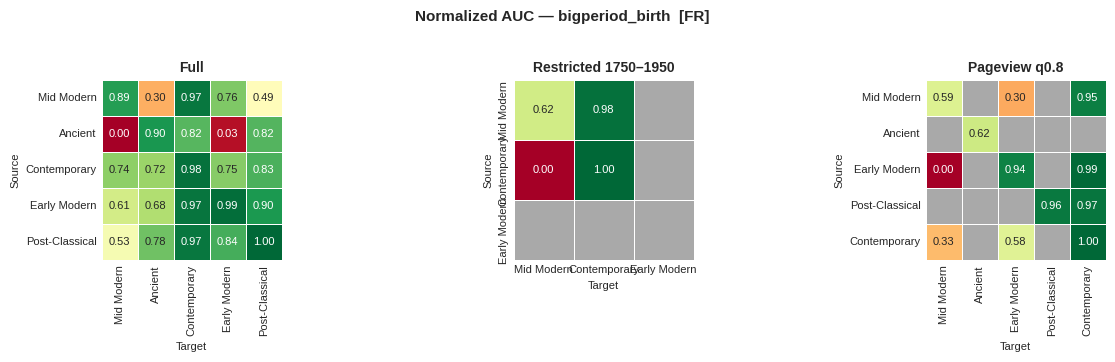

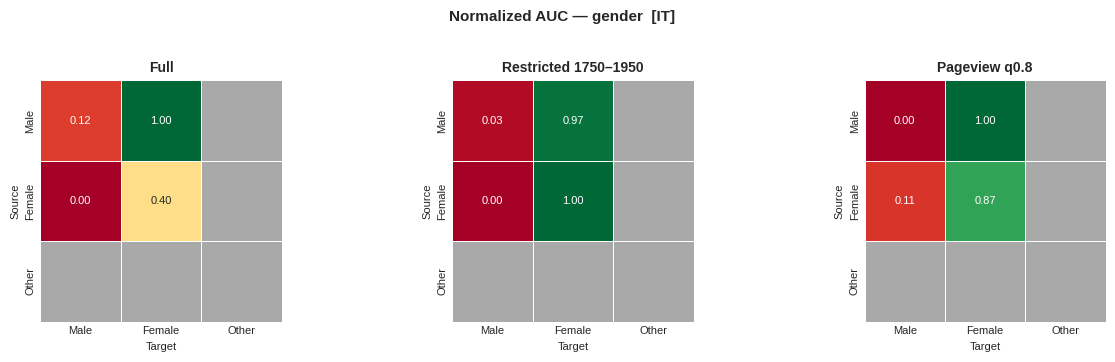

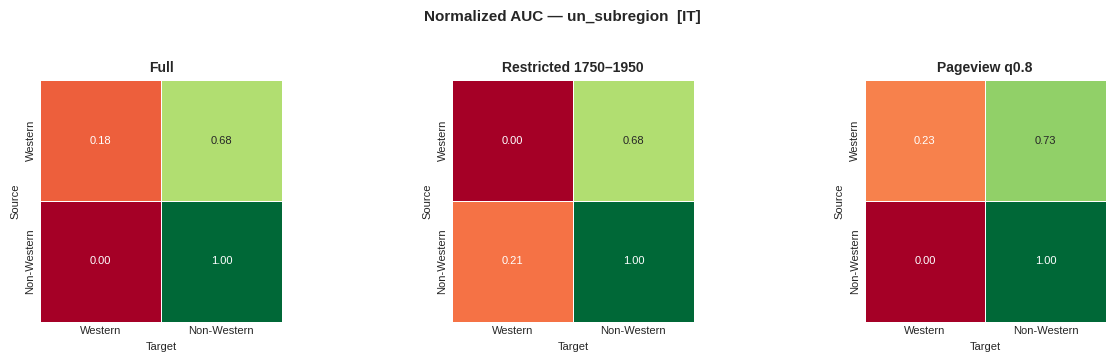

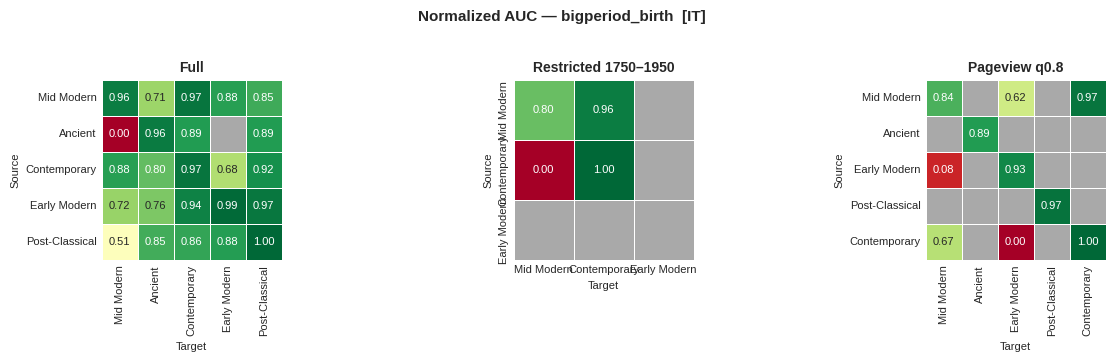

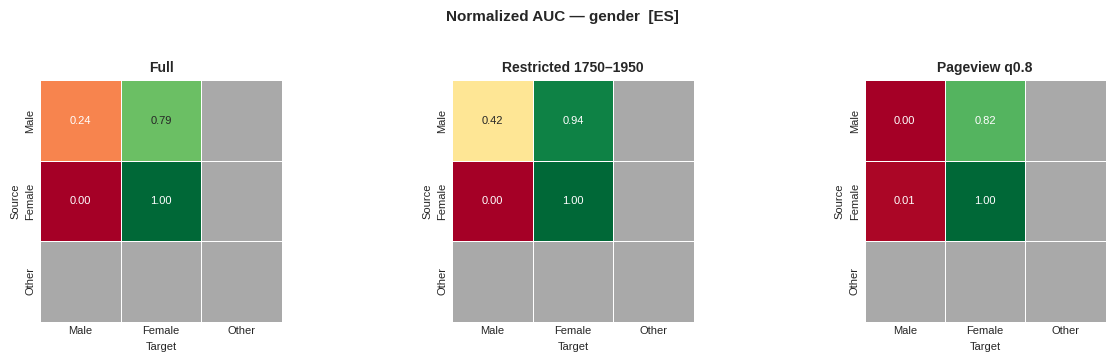

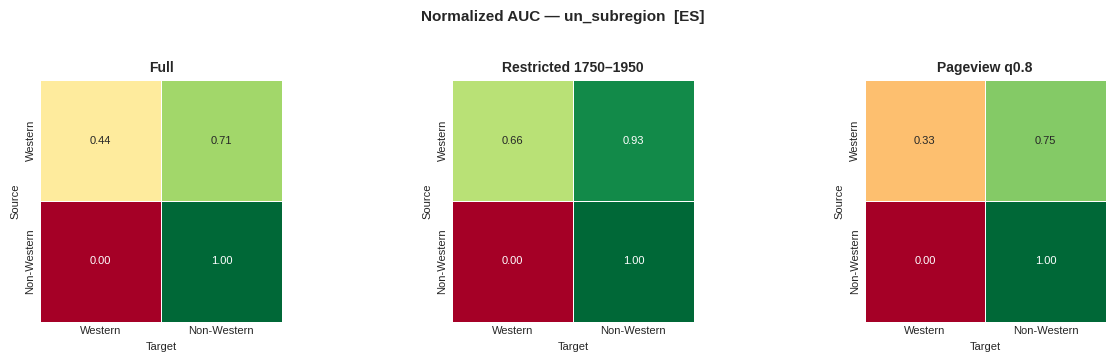

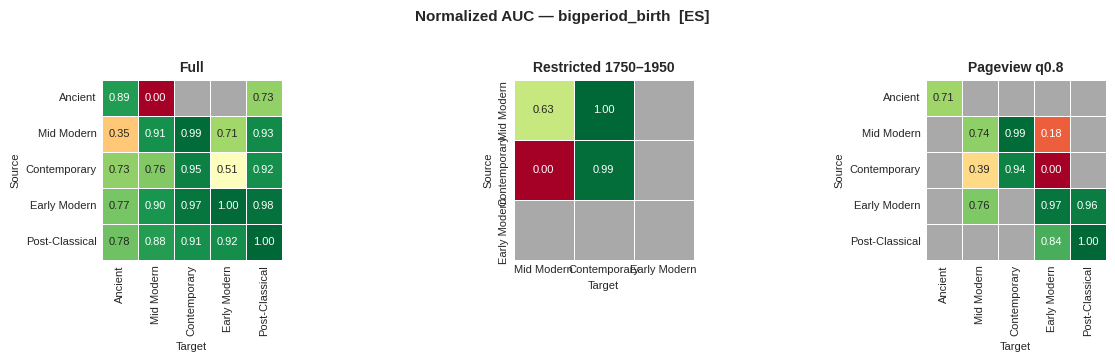

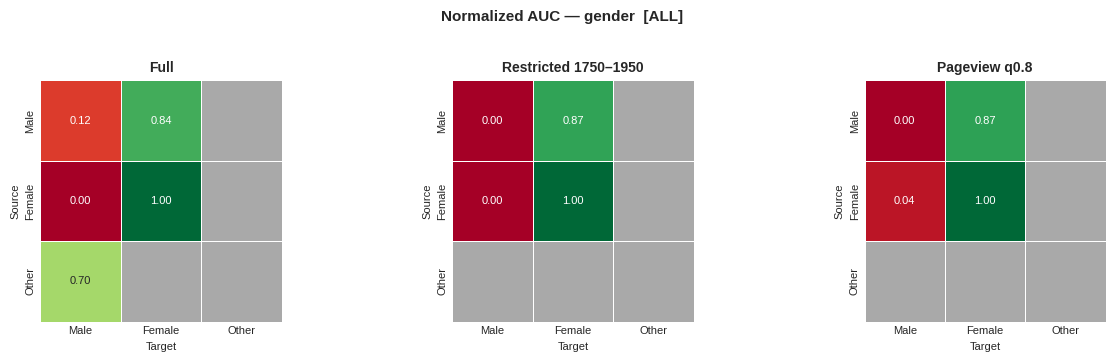

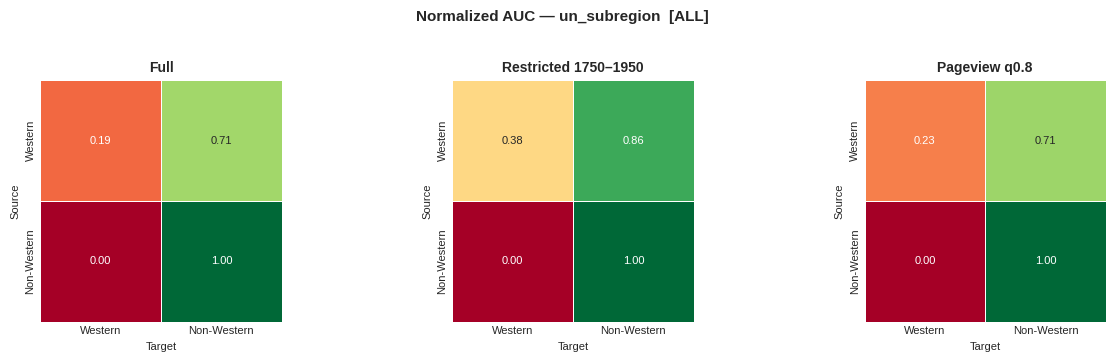

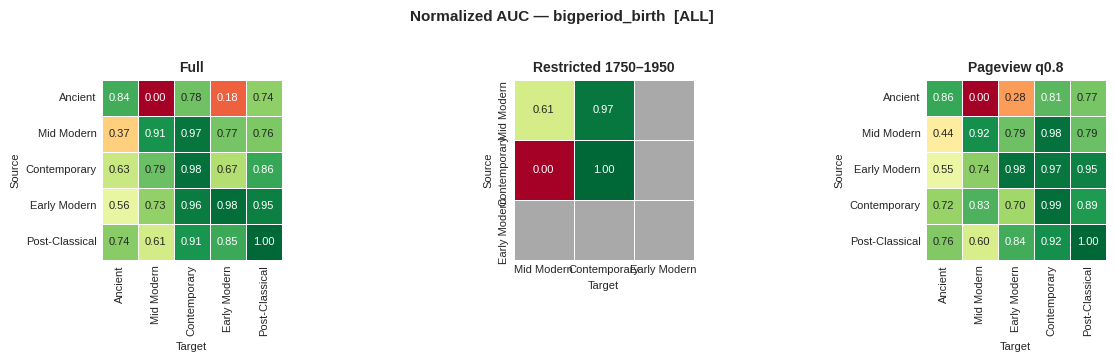

In [5]:
save_heatmap_dir = os.path.join(COMPARISON_OUTPUT_DIR, 'heatmaps') if SAVE_PLOTS else None

for lang in DISPLAY_LANGUAGES:
    for attr in ATTRIBUTES:
        plot_comparison_heatmaps(
            lang, attr, DATASETS, DATASET_LABELS,
            min_edges_val=MIN_EDGES,
            save_dir=save_heatmap_dir
        )

---
## Comparison: Edge Retention Curves

For each (language, attribute) — three edge retention plots side-by-side.

> **Note:** `bigperiod_birth` is excluded from the retention curve plots below — the large number of period×period pairs produces unreadable figures. AUC heatmaps for `bigperiod_birth` are provided in the section above.

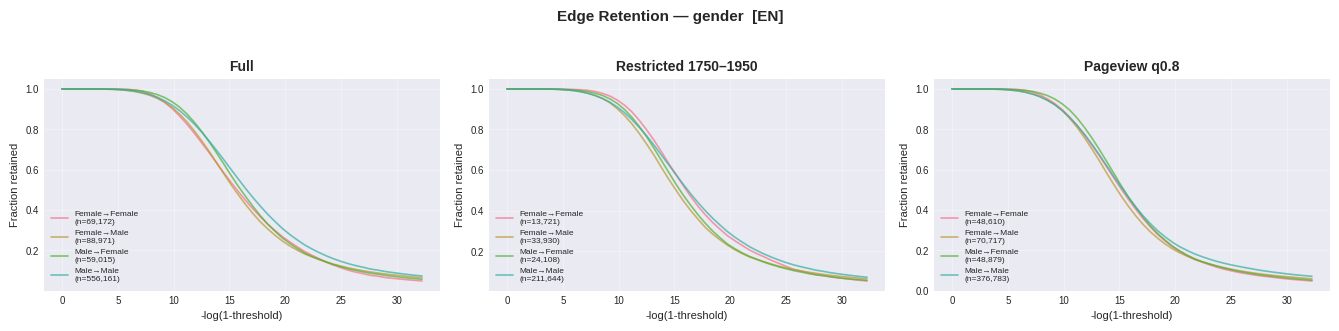

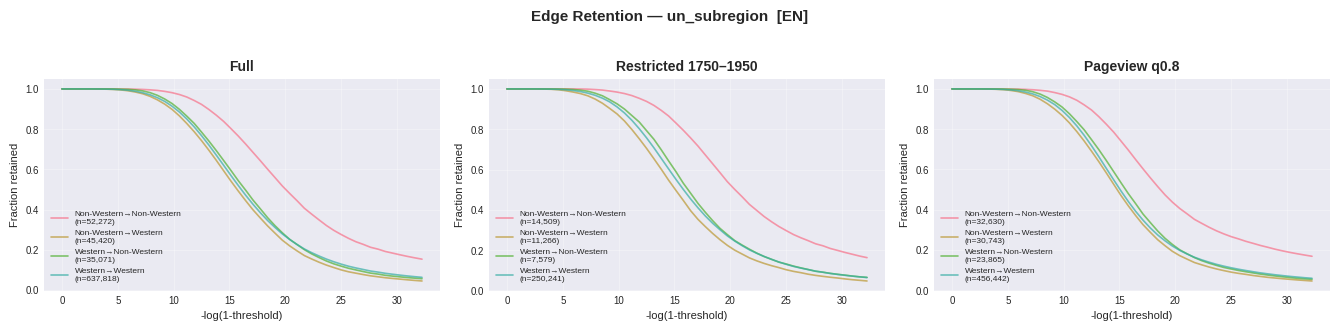

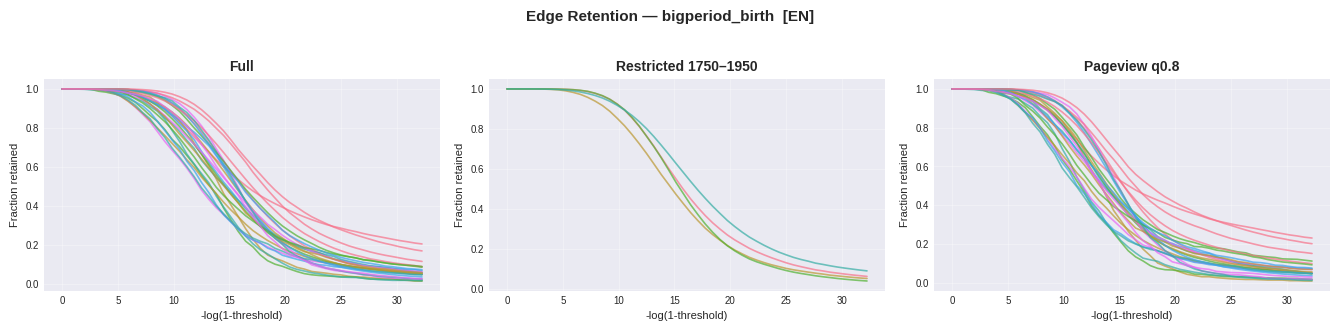

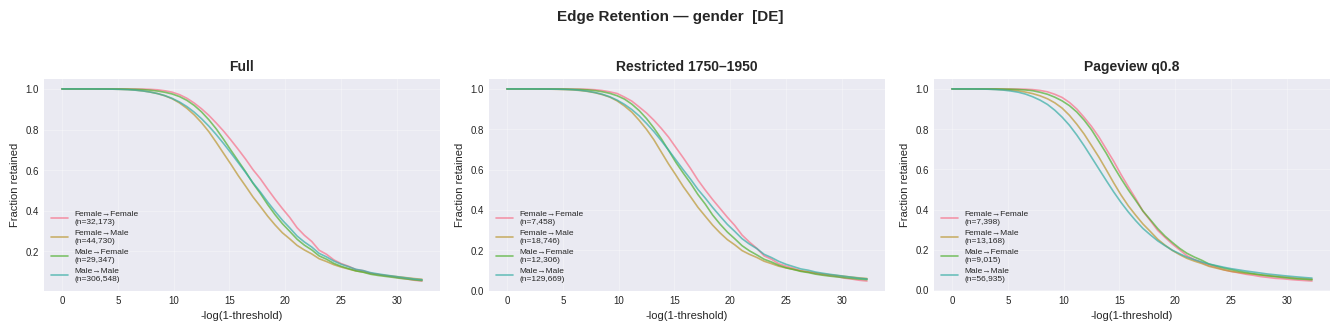

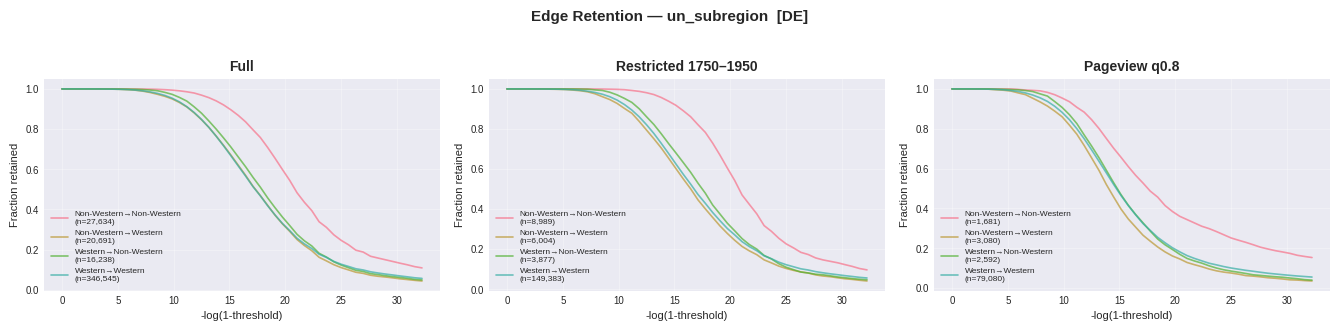

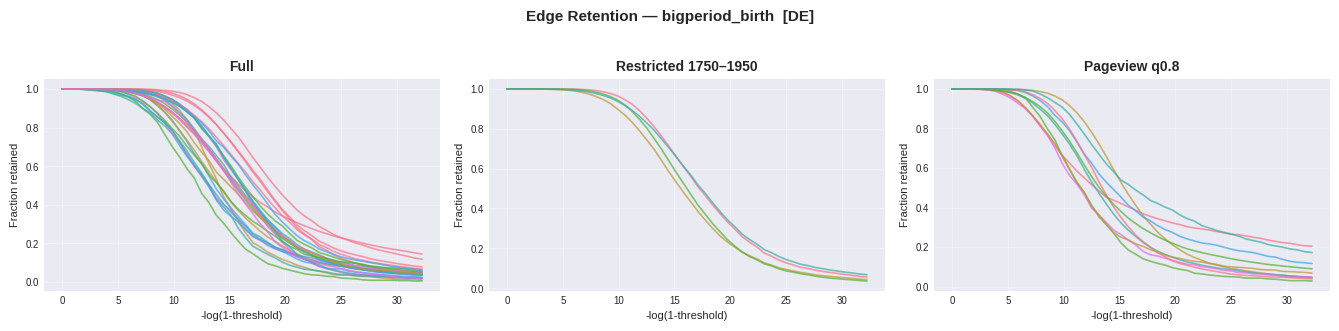

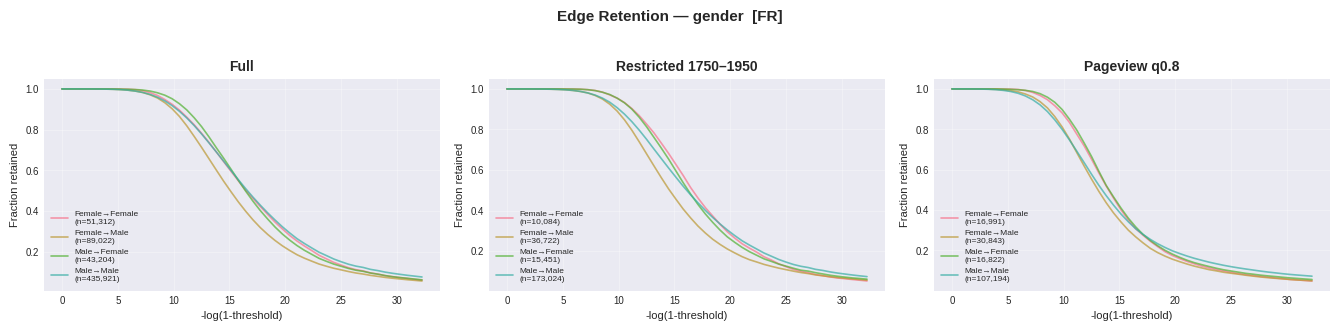

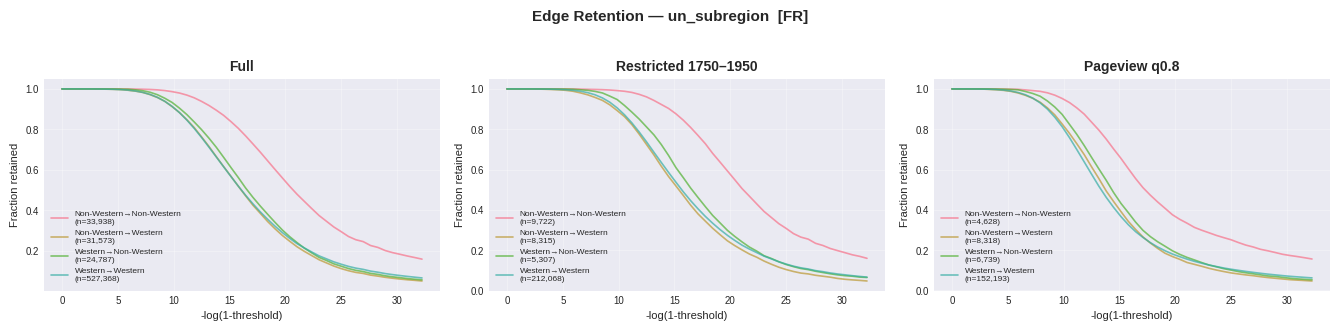

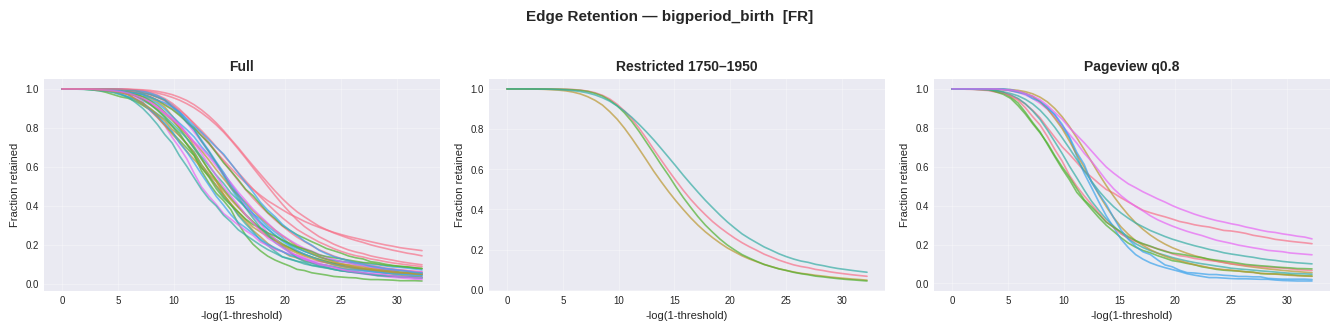

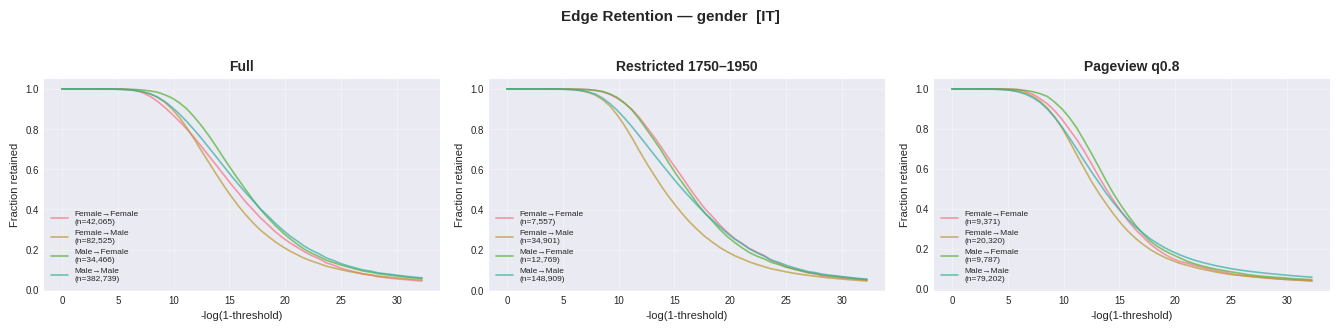

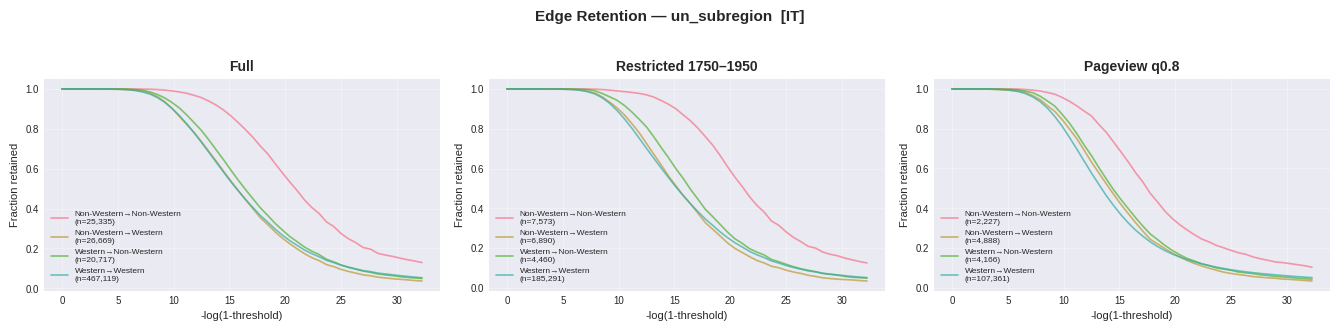

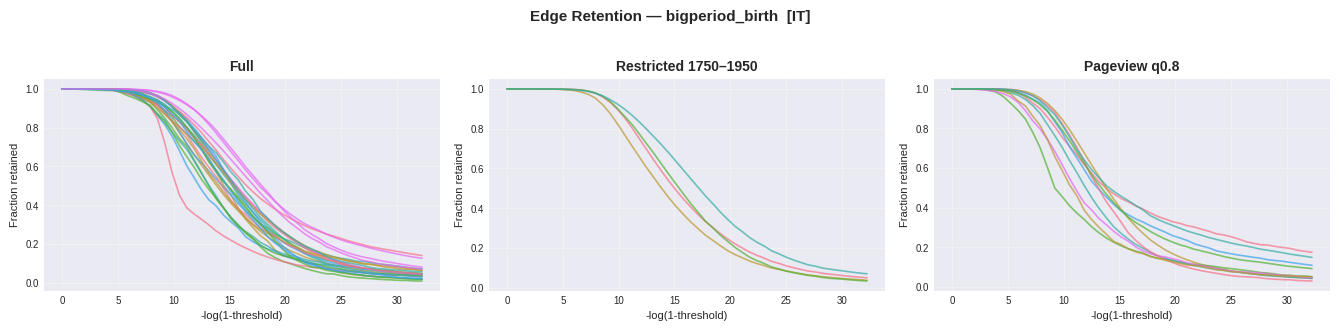

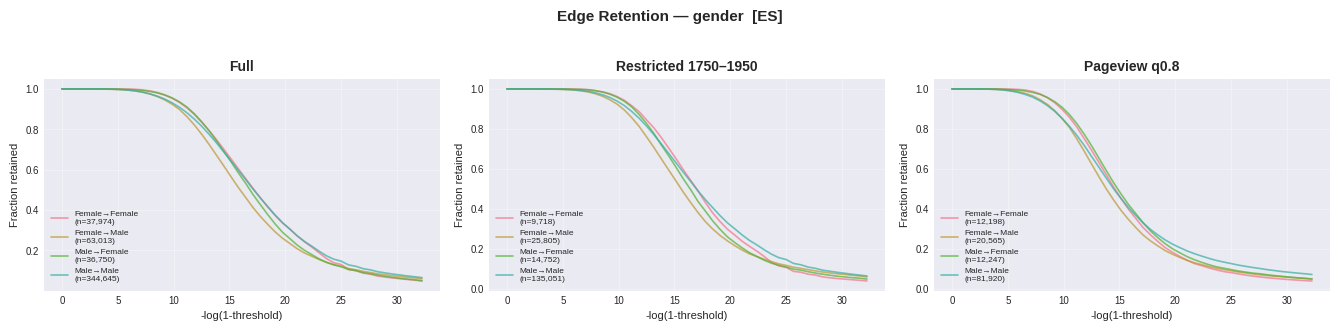

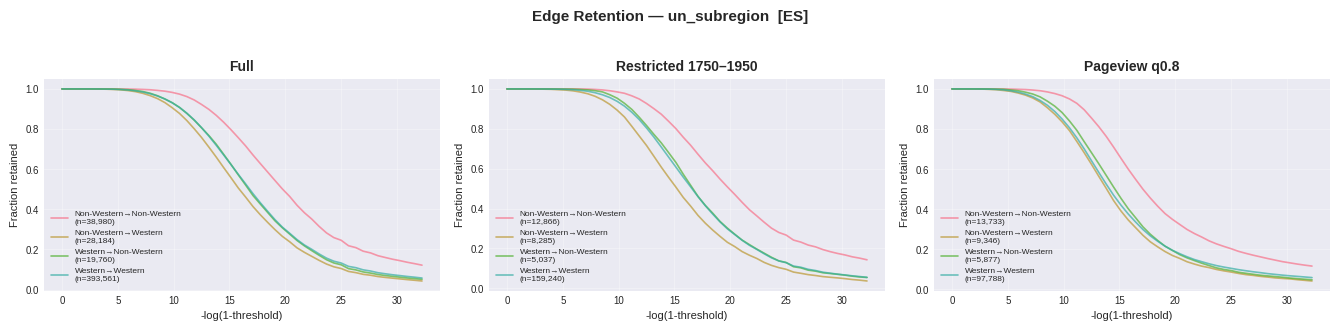

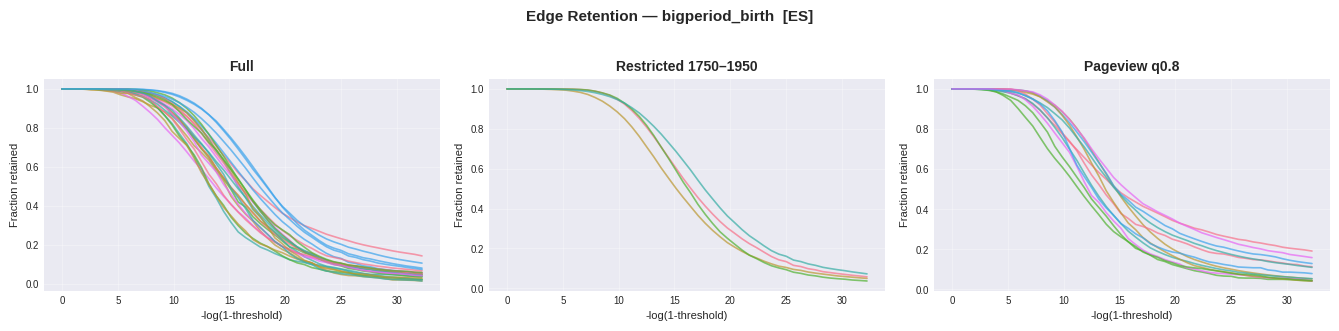

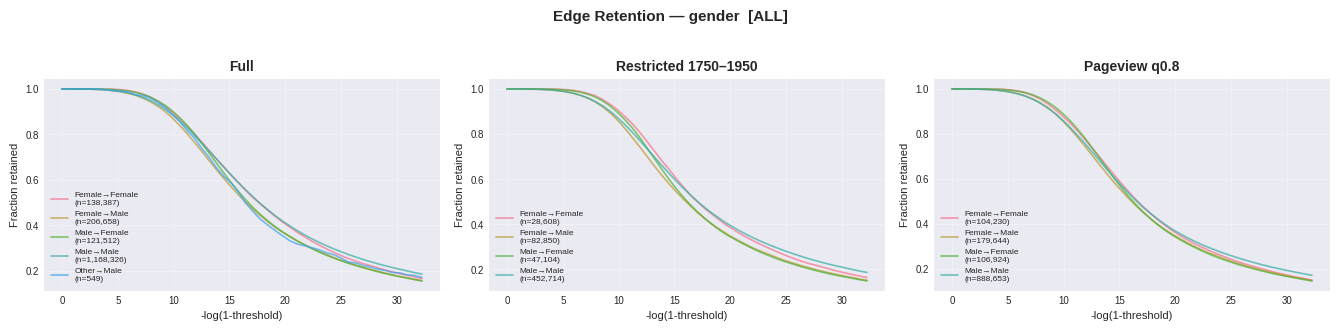

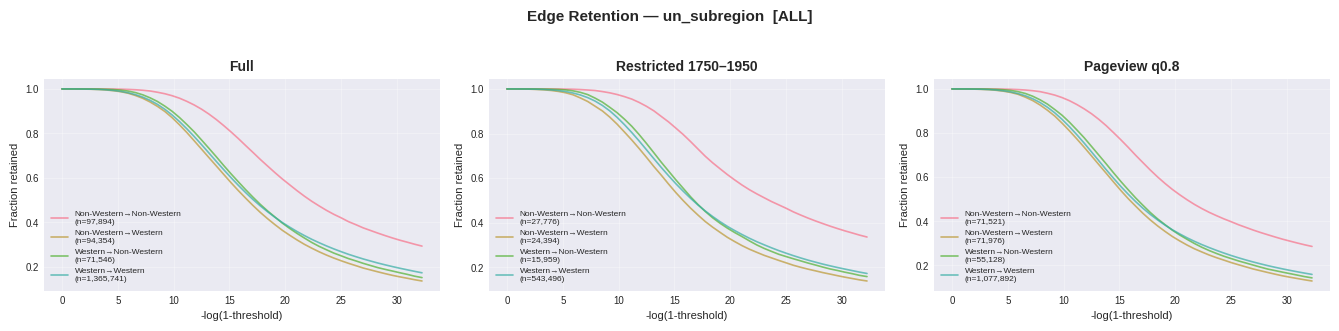

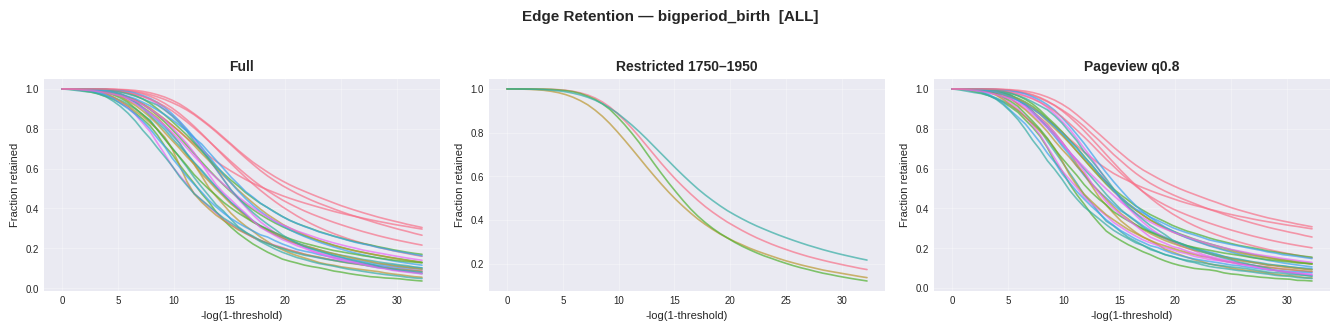

In [6]:
save_edges_dir = os.path.join(COMPARISON_OUTPUT_DIR, 'edge_retention') if SAVE_PLOTS else None

for lang in DISPLAY_LANGUAGES:
    for attr in ATTRIBUTES:
        plot_comparison_curves(
            lang, attr, DATASETS, DATASET_LABELS,
            min_edges_val=MIN_EDGES,
            curve_type='edges',
            save_dir=save_edges_dir,
            show_legend=(attr not in LEGEND_SUPPRESSED_ATTRS)
        )

---
## Comparison: Node Retention Curves

For each (language, attribute) — three node retention plots side-by-side.

> **Note:** `bigperiod_birth` curves are included for completeness. The many categories make these plots dense; legends are hidden for readability. Refer to the heatmaps for label identification.

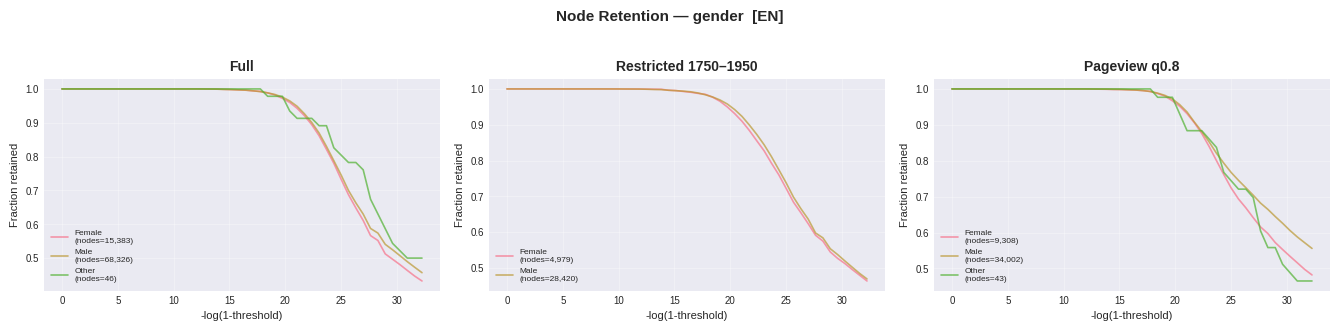

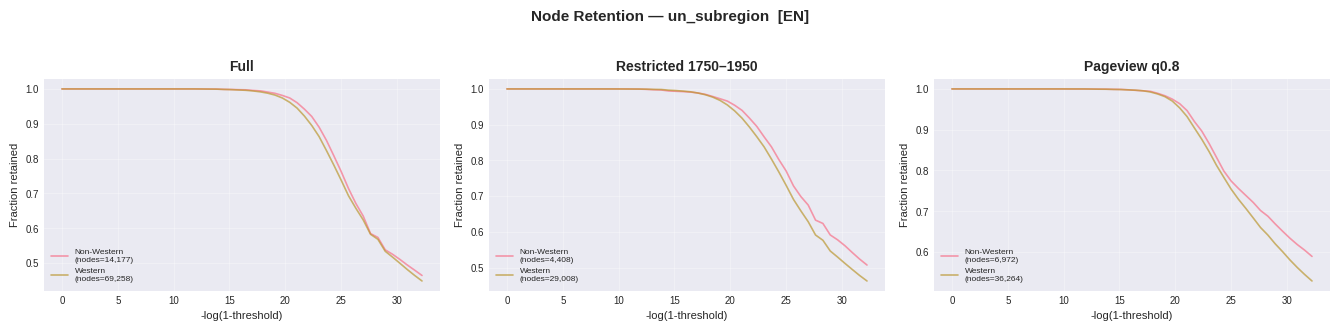

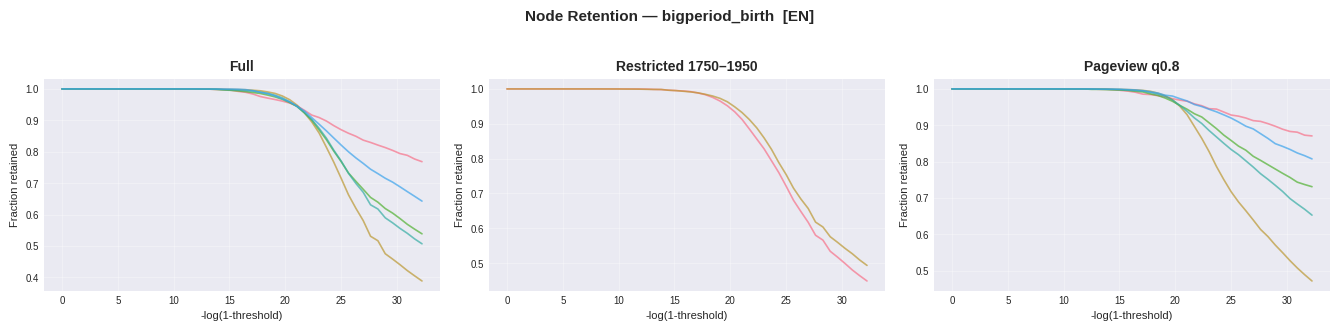

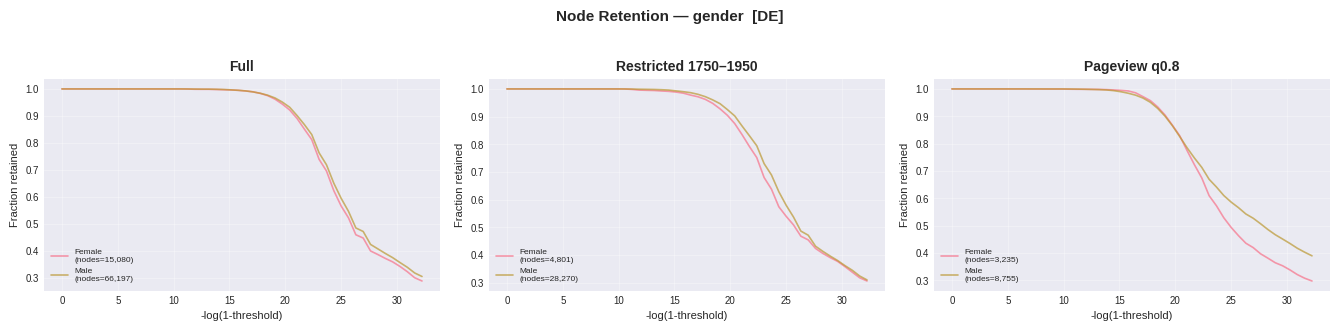

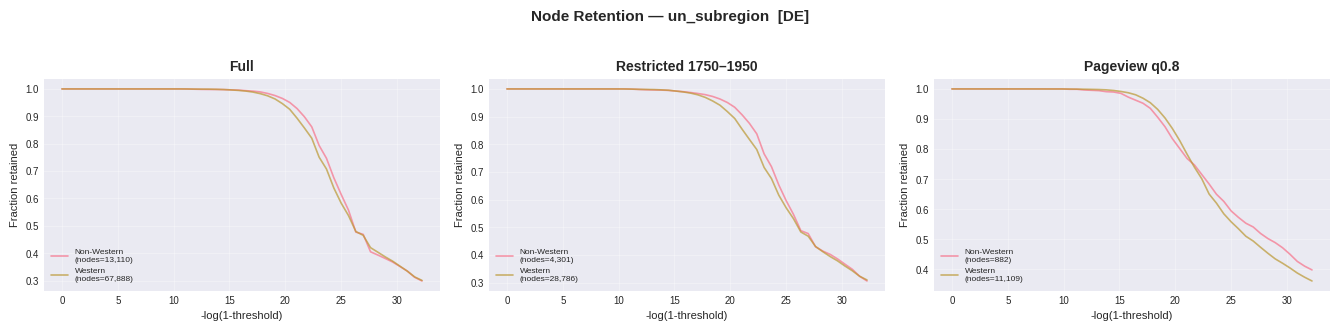

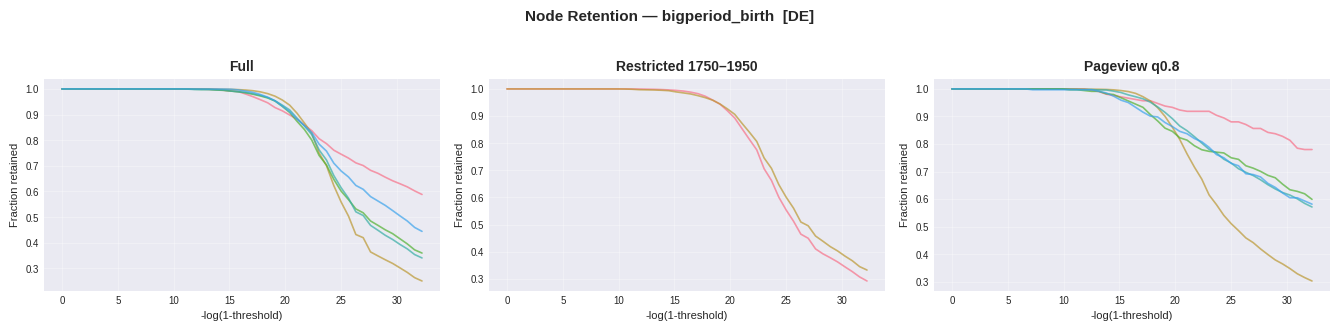

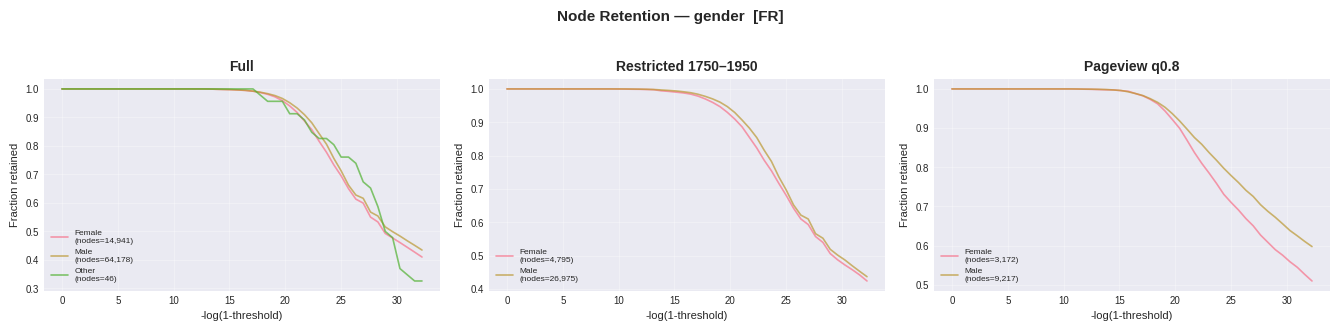

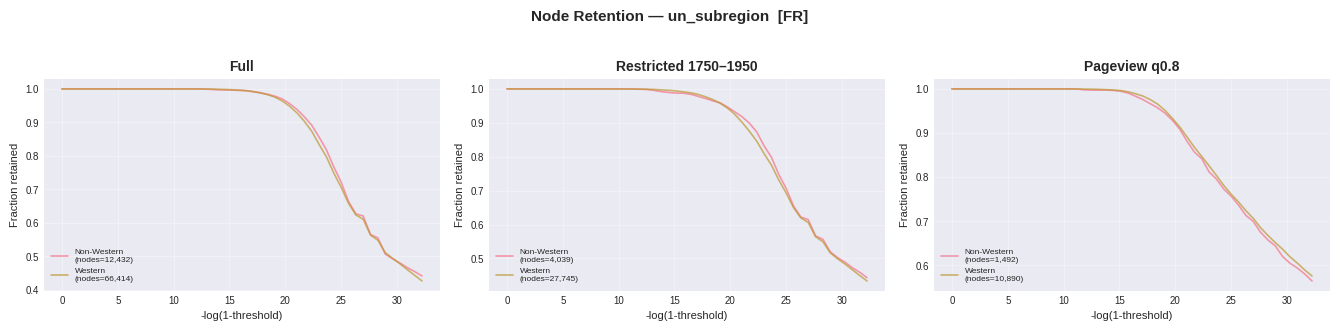

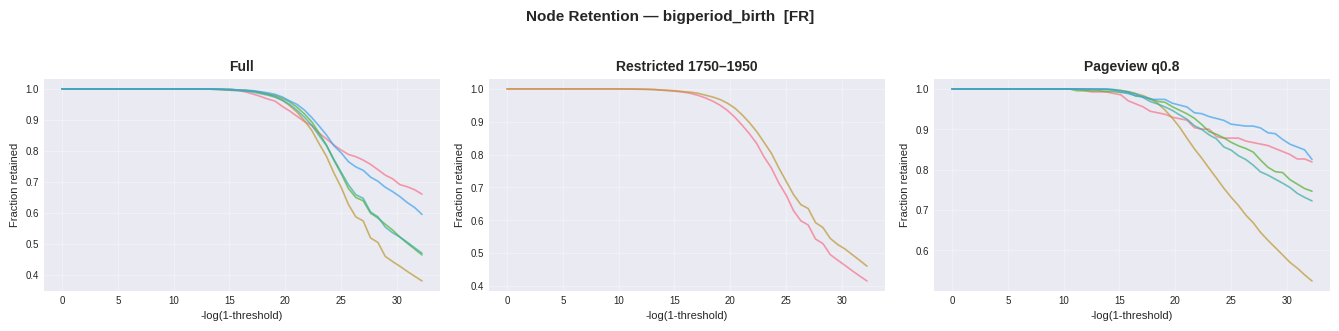

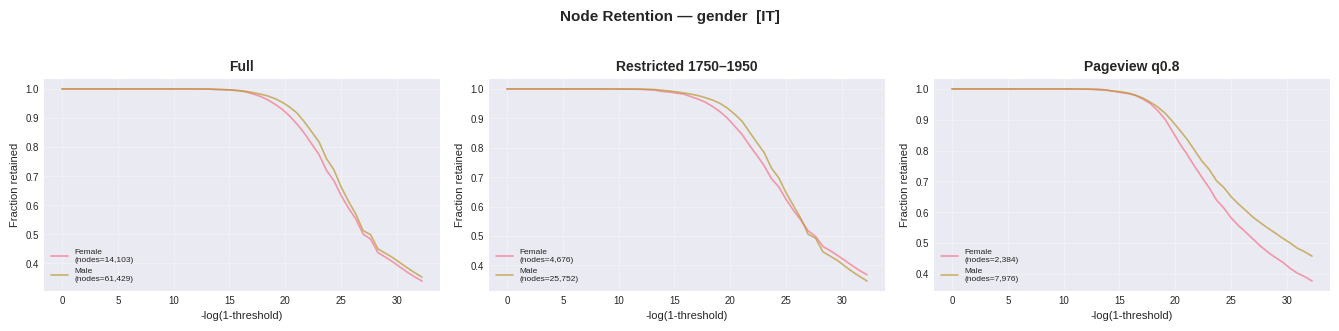

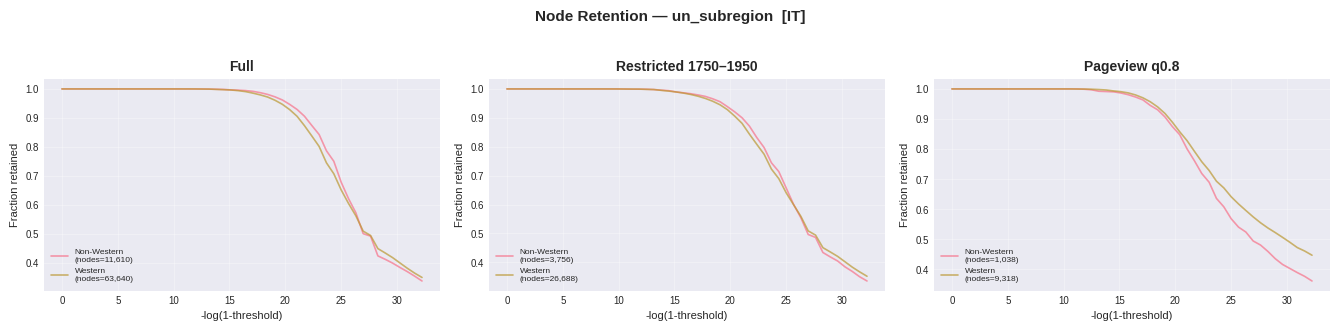

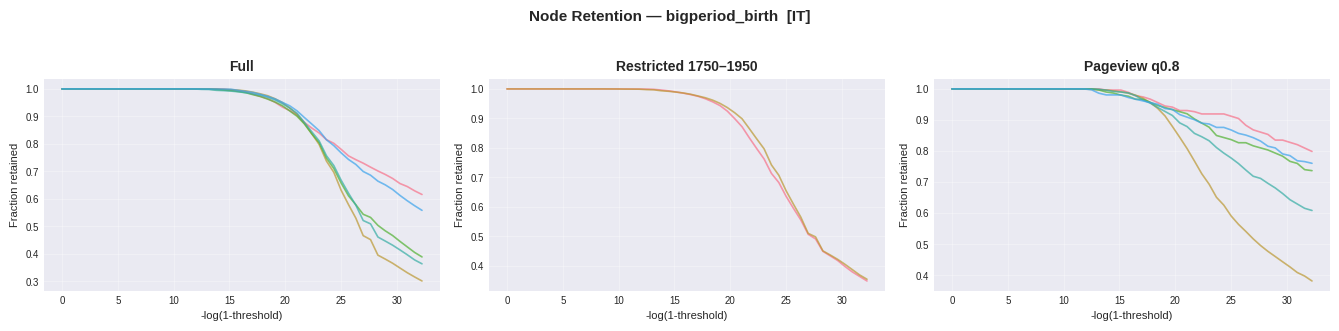

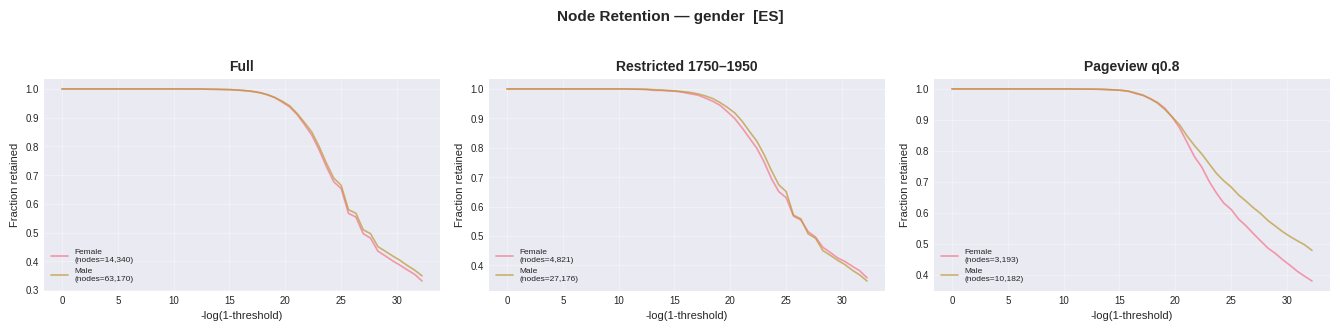

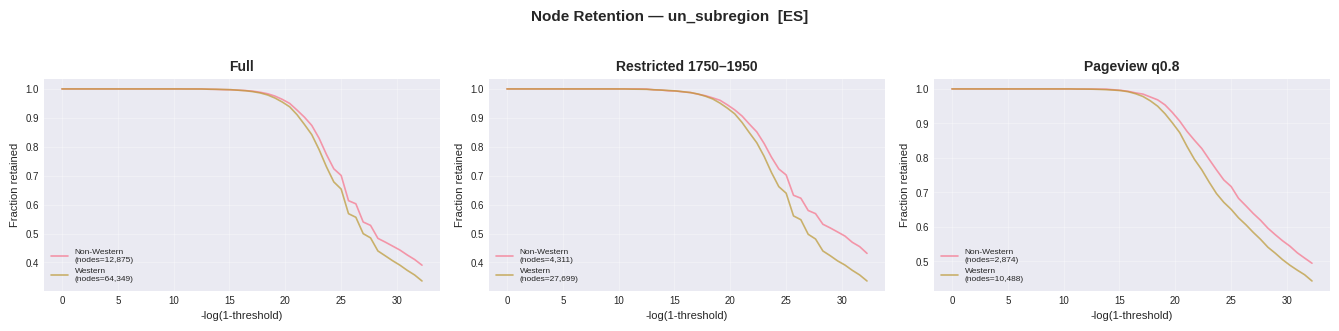

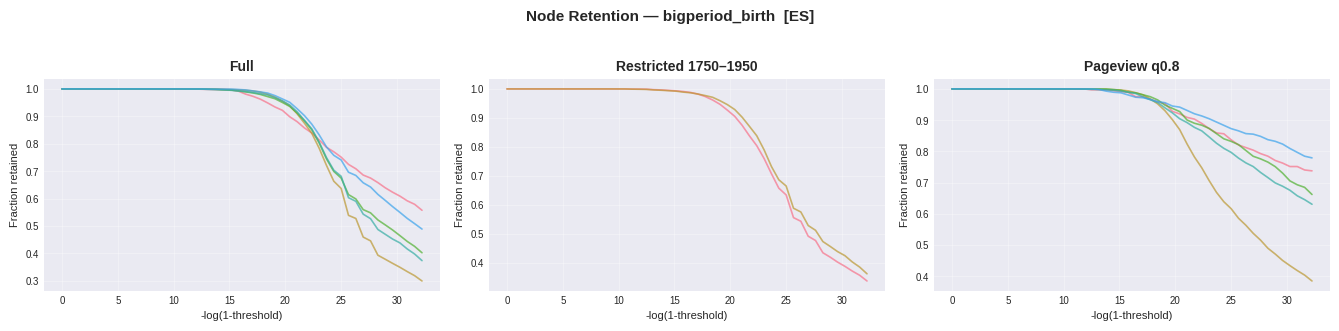

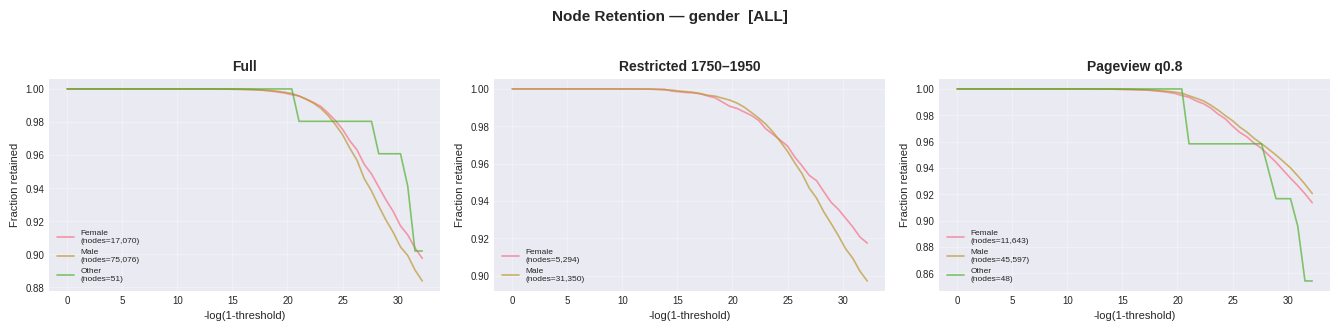

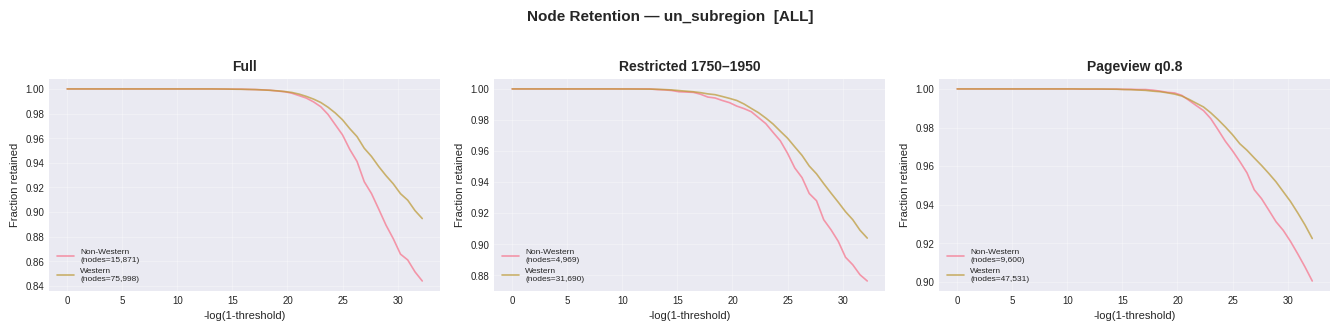

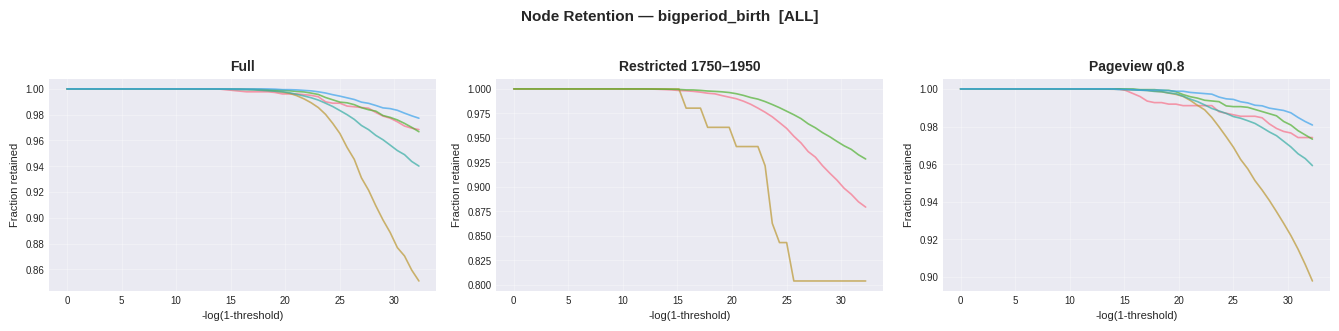

In [7]:
save_nodes_dir = os.path.join(COMPARISON_OUTPUT_DIR, 'node_retention') if SAVE_PLOTS else None

for lang in DISPLAY_LANGUAGES:
    for attr in ATTRIBUTES:
        plot_comparison_curves(
            lang, attr, DATASETS, DATASET_LABELS,
            min_edges_val=MIN_EDGES,
            curve_type='nodes',
            save_dir=save_nodes_dir,
            show_legend=(attr not in LEGEND_SUPPRESSED_ATTRS)
        )

---
## Output Summary

In [8]:
if SAVE_PLOTS:
    n_files = sum(len(files) for _, _, files in os.walk(COMPARISON_OUTPUT_DIR))
    print(f"Comparison plots saved to: {COMPARISON_OUTPUT_DIR}")
    print(f"  Total files: {n_files}")
    for sub in ['heatmaps', 'edge_retention', 'node_retention']:
        d = os.path.join(COMPARISON_OUTPUT_DIR, sub)
        if os.path.isdir(d):
            print(f"  - {sub}/: {len(os.listdir(d))} files")
else:
    print("Plots displayed only (SAVE_PLOTS = False)")

Comparison plots saved to: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/comparison
  Total files: 54
  - heatmaps/: 18 files
  - edge_retention/: 18 files
  - node_retention/: 18 files
